<h1 style="color:#663366; margin-bottom: -40px;"><center>A Comparison of Hybrid and Statistical Forecasting Techniques for Short-Term Energy Demand Forecasting</center></h1>
<h2><center>Matthew Ingram</center></h2>
<p style="color:#663366; margin-bottom: -20px;"><center>Department of Computer Science, Durham University</center></p>


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import torch
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

### 1. Load Data

In [2]:
col_list = ["time", "generation fossil gas", "generation fossil hard coal", "generation fossil oil",
            "generation hydro run-of-river and poundage", "generation hydro water reservoir", "total load forecast",
            "total load actual", "price day ahead", "price actual"]

df = pd.read_csv("data/spain/energy_dataset.csv", parse_dates=["time"], infer_datetime_format=True, usecols=col_list)
df = df.set_index('time').asfreq('H')
df.replace(0, np.NaN, inplace=True)
df.interpolate(inplace=True)
df.head()

,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro run-of-river and poundage,generation hydro water reservoir,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,
2015-01-01 00:00:00+01:00,4844.0,4821.0,162.0,1051.0,1899.0,26118,25385.0,50.10,65.41
2015-01-01 01:00:00+01:00,5196.0,4755.0,158.0,1009.0,1658.0,24934,24382.0,48.10,64.92
2015-01-01 02:00:00+01:00,4857.0,4581.0,157.0,973.0,1371.0,23515,22734.0,47.33,64.48
2015-01-01 03:00:00+01:00,4314.0,4131.0,160.0,949.0,779.0,22642,21286.0,42.27,59.32
2015-01-01 04:00:00+01:00,4130.0,3840.0,156.0,953.0,720.0,21785,20264.0,38.41,56.04


### 2. Load Model

In [3]:
model = torch.load("/Users/matt/Projects/AdvancedResearchProject/models/demo_model.pt")
model.eval()

ES_RNN_I(
  (drnn): DRNN(
    (rnn_layer_0): LSTM(9, 40)
    (rnn_layer_1): LSTM(40, 40)
    (rnn_layer_2): LSTM(40, 40)
    (rnn_layer_3): LSTM(40, 40)
  )
  (tanh): Tanh(
    (linear): Linear(in_features=40, out_features=40, bias=True)
  )
  (linear): Linear(in_features=40, out_features=48, bias=True)
)

### 3. Split Data

In [4]:
# Input/Actual Data
data = df.loc["2017-03-01 00:00:00+01:00":"2017-05-31 23:00:00+01:00"]
data_in = data[-(15 * 24 + 336): -(15 * 24)]
data_out = data[-(15 * 24): -(15 * 24 - 48)]

# Input/Predicted Levels
levels = [l.item() for l in model.levels["total load actual"]]
levels_in = levels[-336:]
levels_out = [levels_in[-1] for _ in range(48)]

#Input/Predicted Seasonality Values
seasonals = [s.item() for s in model.seasonals["total load actual"]]
seas_in = seasonals[-336:]
seas_out = seasonals[-168:-120]

### 4. Plot *Total Load Actual* Input and Actual Output

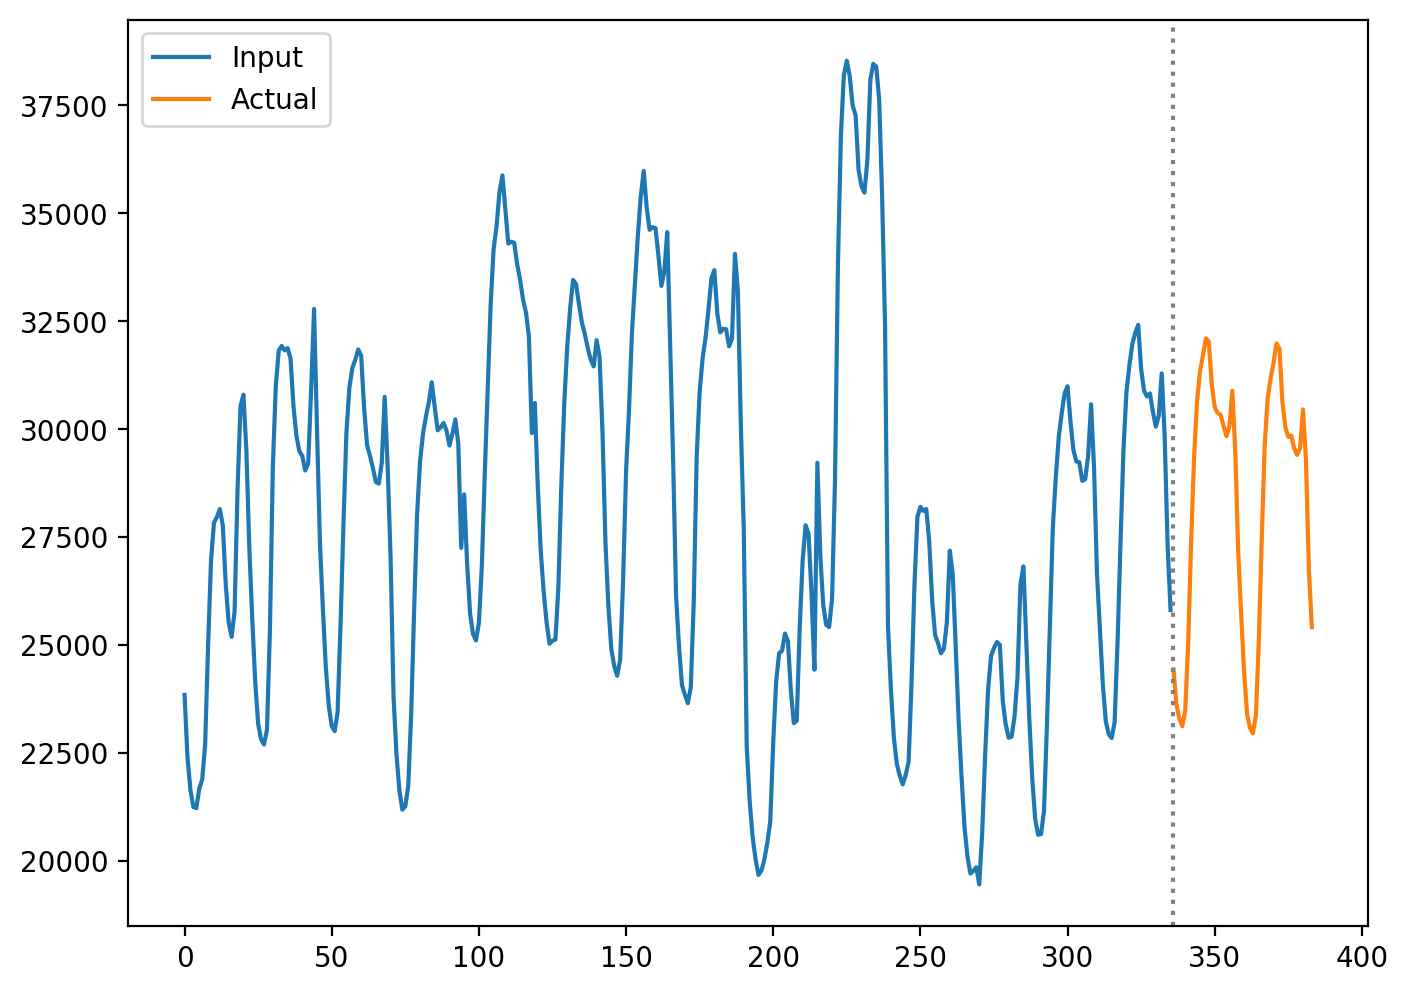

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=200)
ax.plot([i for i in range(336)], data_in["total load actual"], label="Input")
ax.plot([i for i in range(336, 384)], data_out["total load actual"], label="Actual")
ax.axvline(x=336, color="grey", linestyle=":")
ax.legend(loc="upper left")
plt.show()

### 5. Plot Fitted Exponential Smoothing Values of *Total Load Actual*

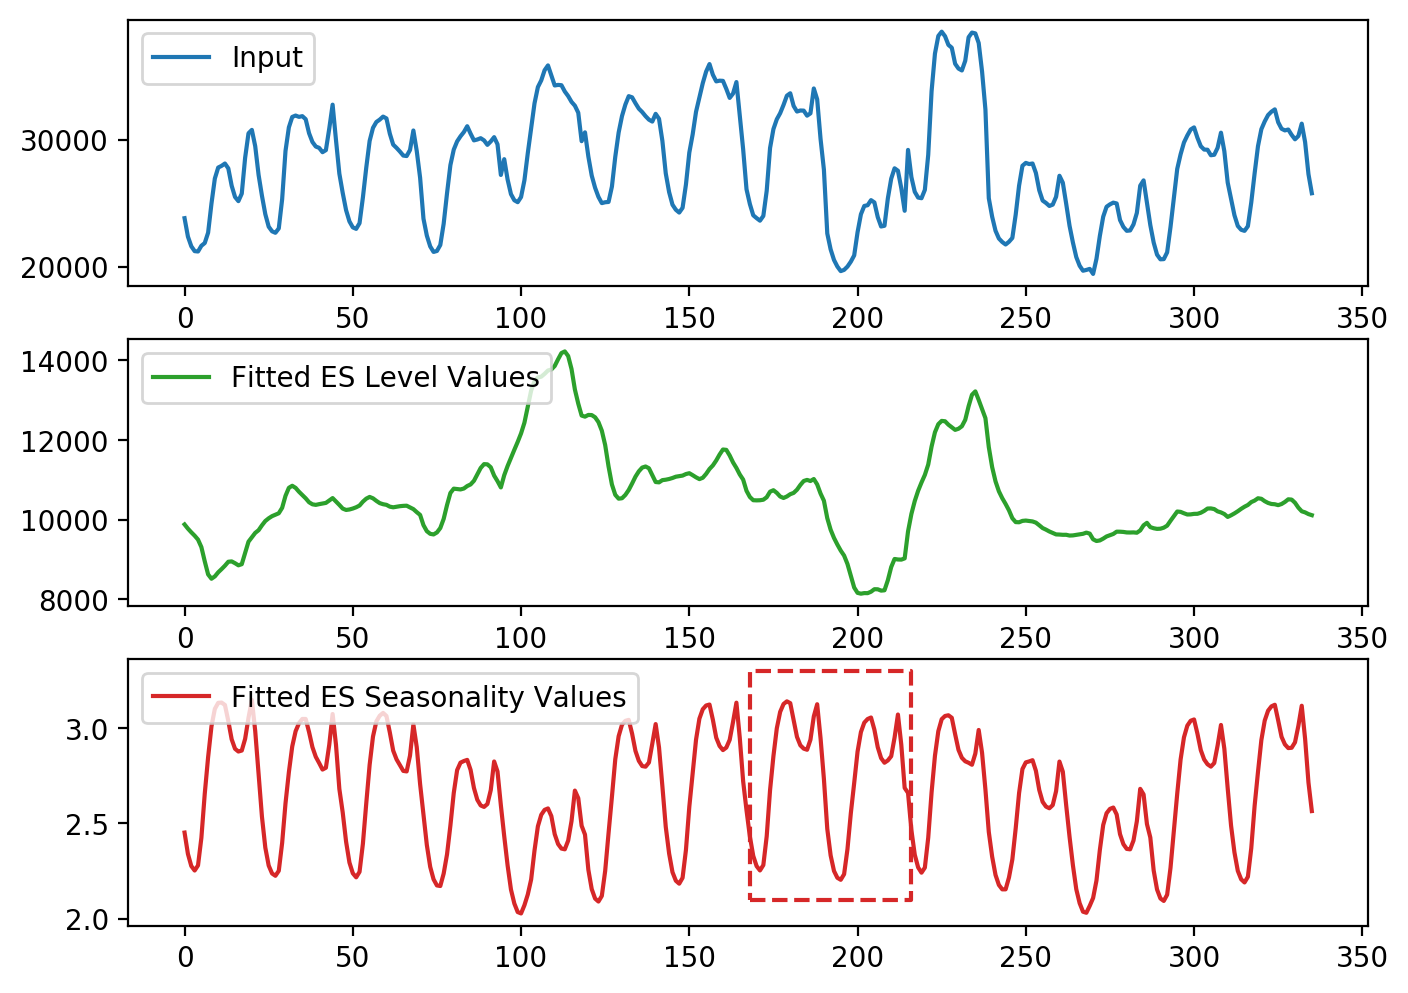

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6), dpi=200)
axes[0].plot([i for i in range(336)], data_in["total load actual"], label="Input")
axes[1].plot(levels_in, label="Fitted ES Level Values", color="C2")
axes[2].plot(seas_in, label="Fitted ES Seasonality Values", color="C3")
axes[2].plot([168, 216, 216, 168, 168], [2.1, 2.1, 3.3, 3.3, 2.1], color="C3", linestyle="--")
for ax in axes:
    ax.legend(loc="upper left")
plt.show()

### 6. De-seasonalise and Normalise *Total Load Actual*

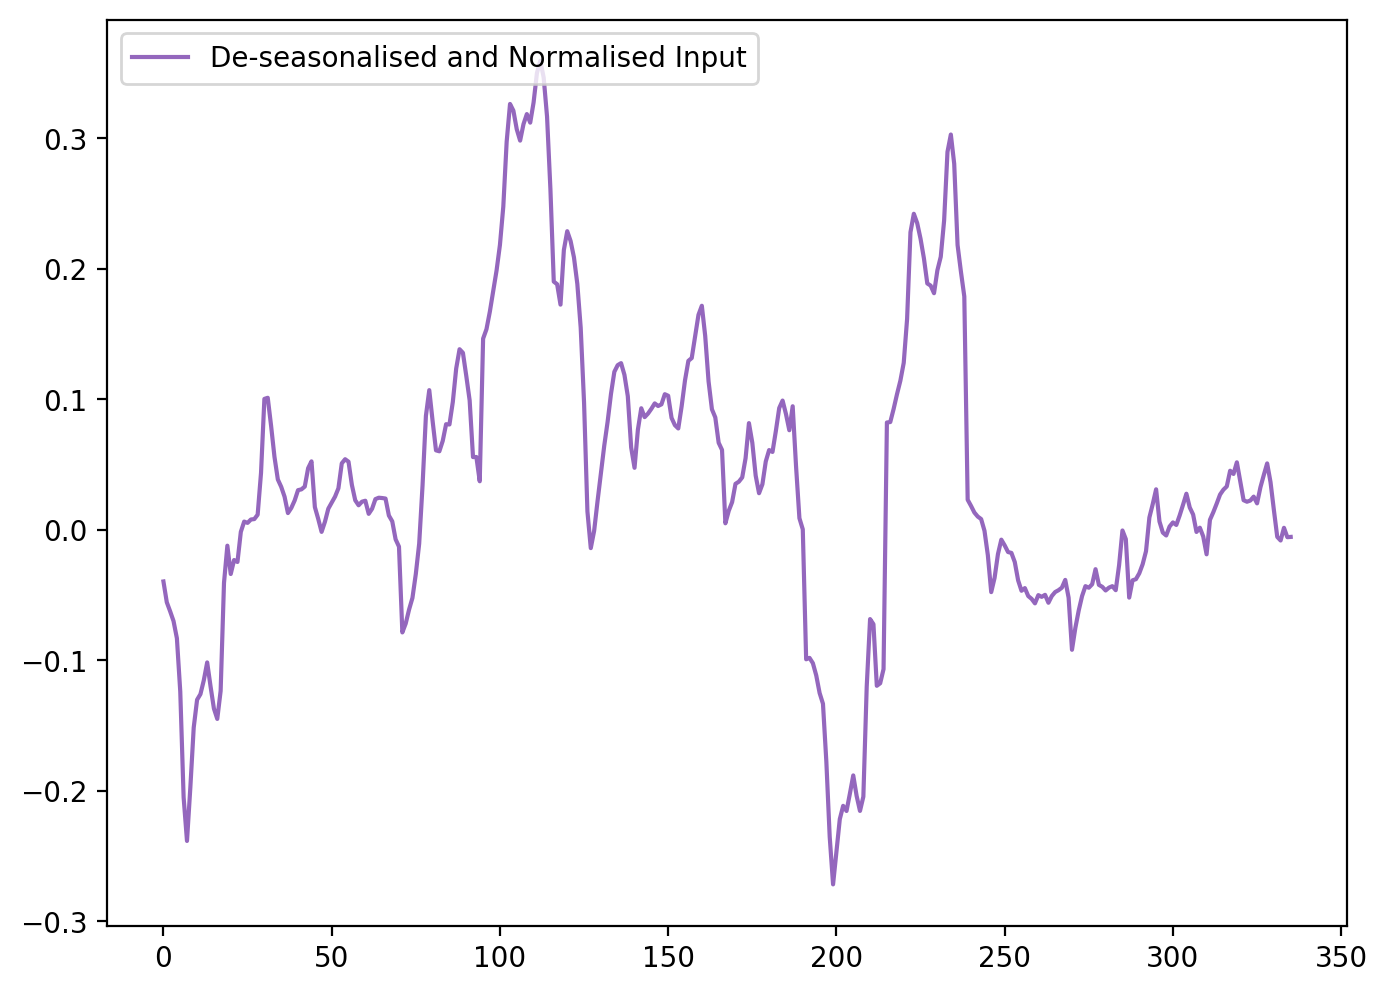

In [7]:
# De-seasonalise and normalise
norm_input = np.log(np.array(data_in["total load actual"]) / (np.array(seas_in) * levels_in[-1]))

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=200)
ax.plot(norm_input, label="De-seasonalised and Normalised Input", color="C4")
ax.legend(loc="upper left")
plt.show()

### 7. Normalise all Time Series and form Input Tensor

In [8]:
inputs = []

for f in model.demand_features:
    inp = torch.tensor(data_in[f], dtype=torch.double)
    level = torch.tensor(model.levels[f][-1], dtype=torch.double)
    seasonals = torch.tensor(model.seasonals[f][-336:], dtype=torch.double)
    norm_input = torch.log(inp / (level * seasonals)).unsqueeze(0)
    inputs.append(norm_input.unsqueeze(2))
    
inputs = torch.cat(inputs, dim=2)
inputs.size()

torch.Size([1, 336, 9])

### 8. Input into dLSTM

In [9]:
# Pass inputs through the dLSTM (dRNN)
_, hidden_layers = model.drnn(inputs)

lstm_out = hidden_layers[0][-1][:, -inputs.size(0):, :].view(-1, model.hidden_size)
print("dLSTM Output Size:", lstm_out.size())

dLSTM Output Size: torch.Size([1, 40])


### 9. Pass dLSTM Output Through *Tanh* and Linear Layer

Final Output Size: torch.Size([1, 48])


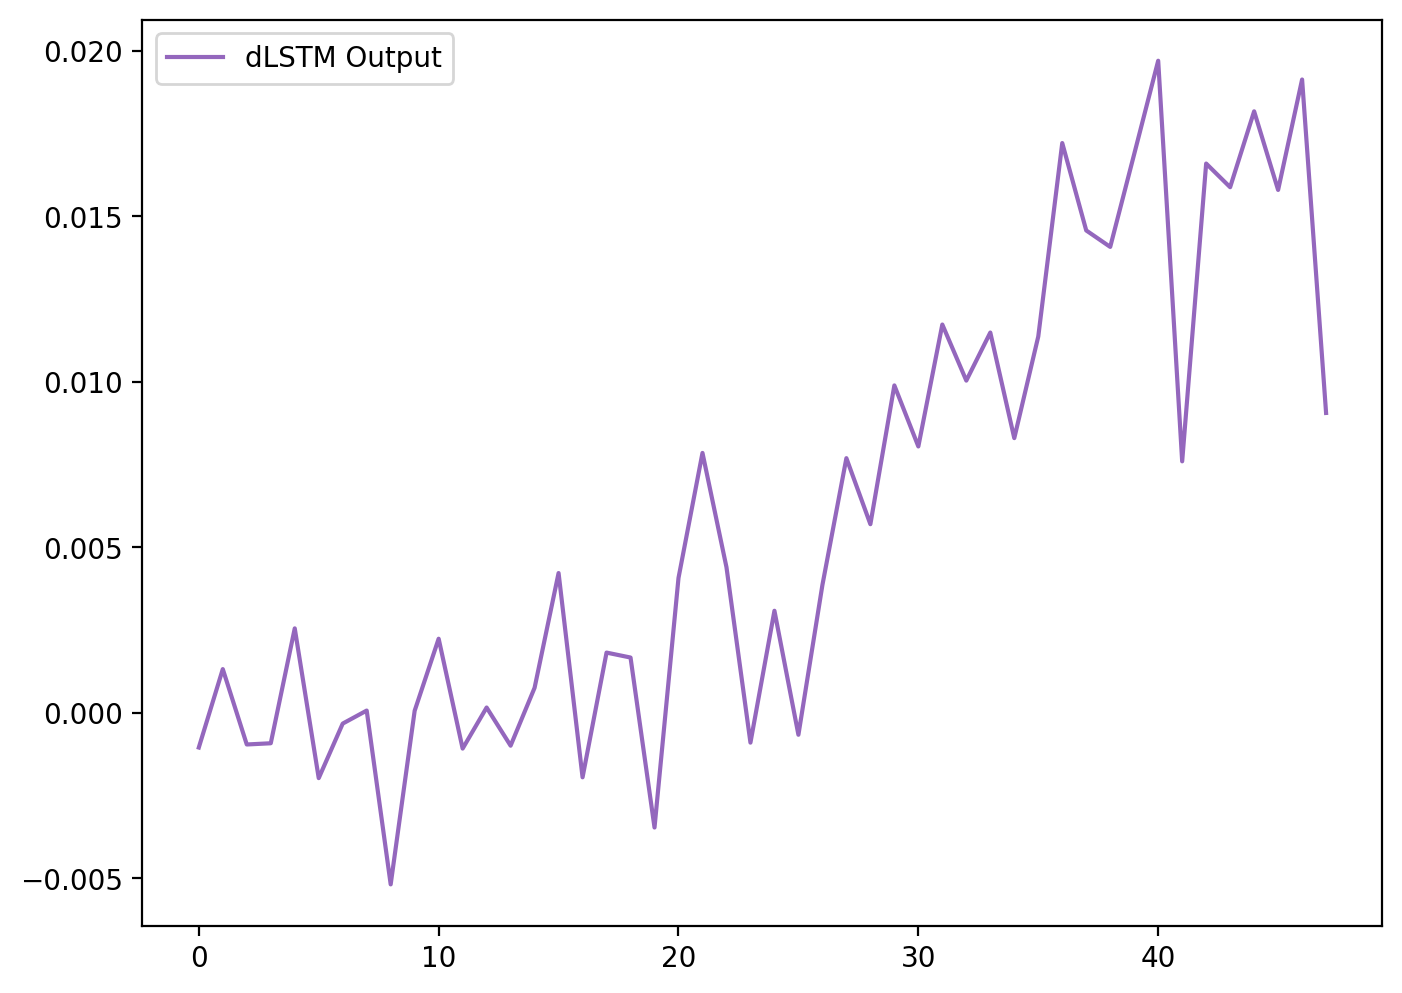

In [10]:
# Pass dLSTM output through tanh and linear layers
out = model.linear(model.tanh(lstm_out))

print("Final Output Size:", out.size())
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=200)
ax.plot(out.detach().view(-1), label="dLSTM Output", color="C4")
ax.legend(loc="upper left")
plt.show()

### 10. Extrapolated Level and Repeated Seasonality Values

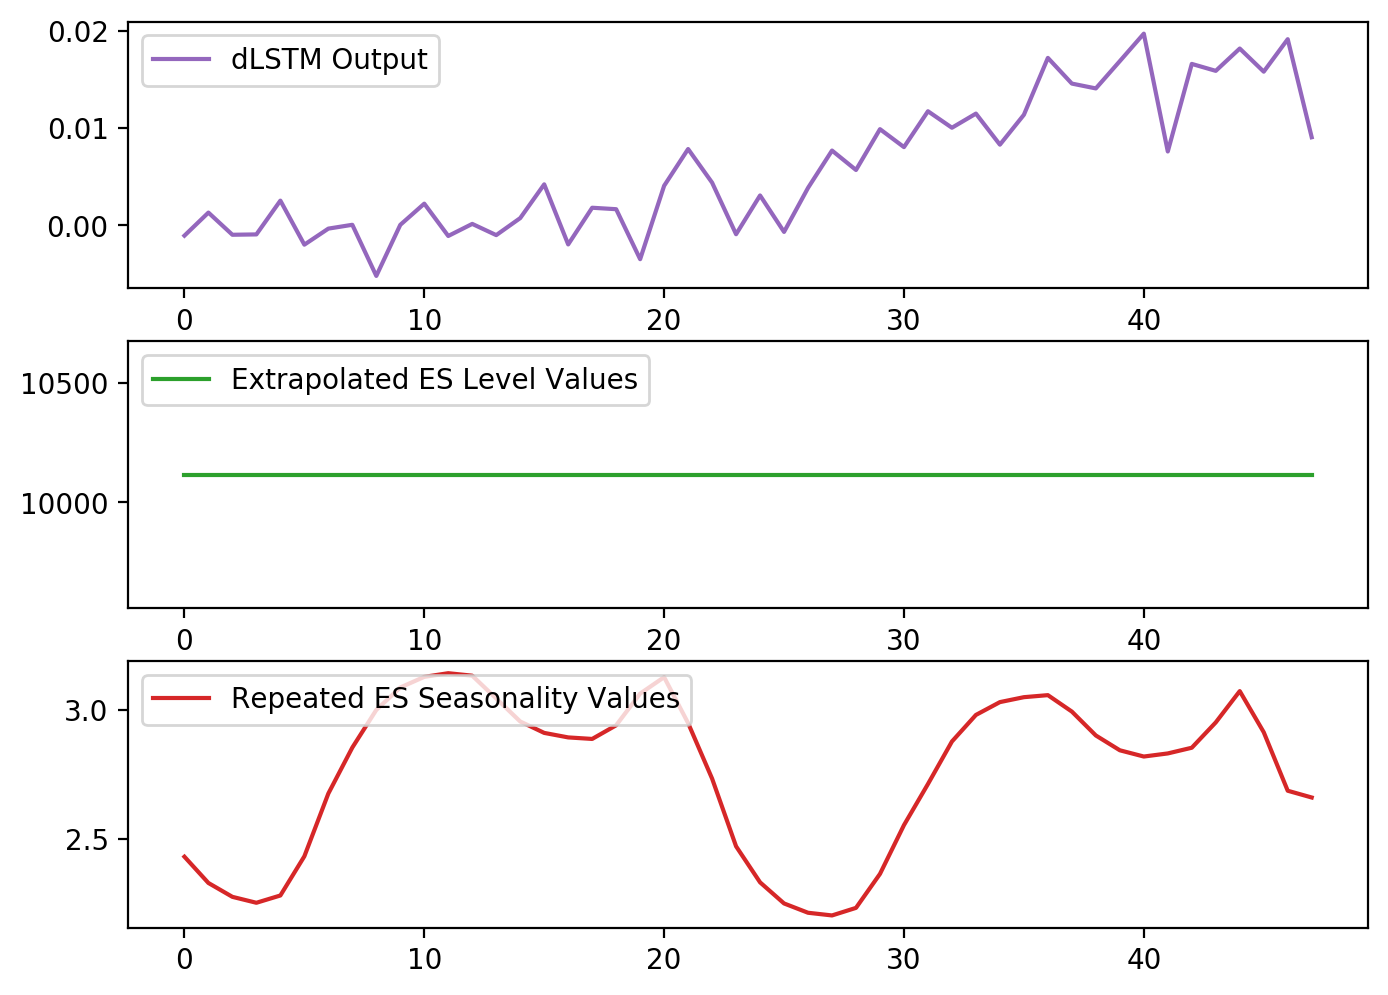

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6), dpi=200)
axes[0].plot(out.detach().view(-1), label="dLSTM Output", color="C4")
axes[1].plot(levels_out, label="Extrapolated ES Level Values", color="C2")
axes[2].plot(seas_out, label="Repeated ES Seasonality Values", color="C3")
for ax in axes:
    ax.legend(loc="upper left")
plt.show()

### 11. Re-seasonalise and De-normalise to give Final Forecast

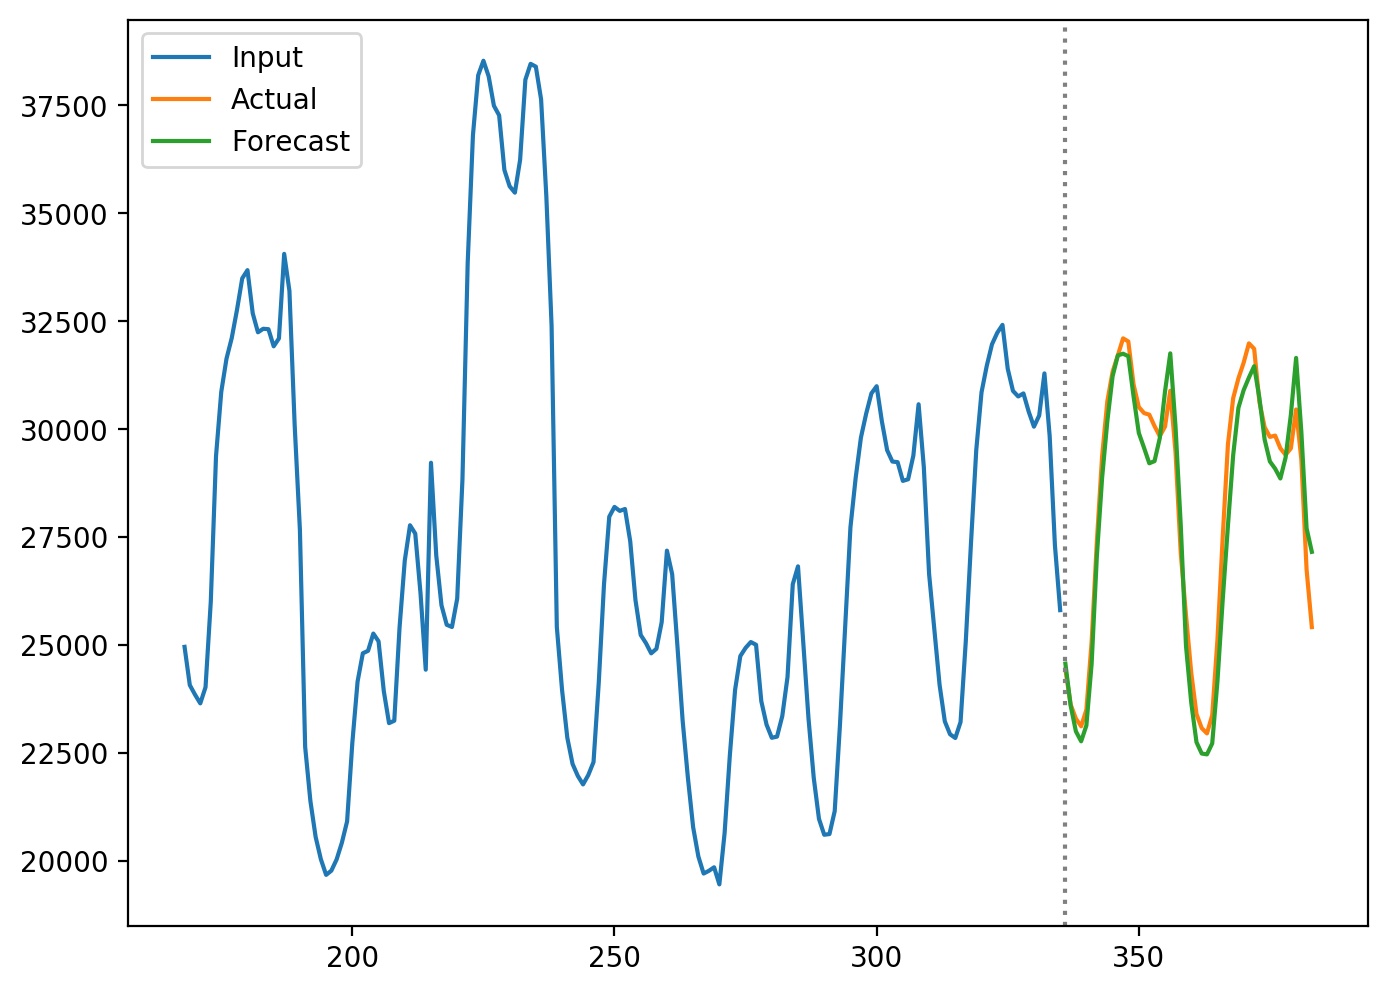

In [12]:
# Re-seasonalise and de-seasonalise
forecast = torch.exp(out).detach().view(-1).numpy() * np.array(levels_out) * np.array(seas_out)
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=200)
ax.plot([i for i in range(168, 336)], data_in["total load actual"][168:336], label="Input")
ax.plot([i for i in range(336, 384)], data_out["total load actual"], label="Actual")
ax.plot([i for i in range(336, 384)], forecast, label="Forecast", color="C2")
ax.axvline(x=336, color="grey", linestyle=":")
ax.legend(loc="upper left")
plt.show()

<h1 style="color:#663366; margin-bottom: -40px;"><center>Thank You For Listening</center></h1>
<h2><center>Any Questions?</center></h2>